# **HW5**

1. validation data  를 따로 분리하여 overfitting  점검하고 해결하기
2. 시계열 출력층에 L1   규제화를 부여하고 lambda  값을 변화시켜 overfitting  관점에서 설명하기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime

In [2]:
# 주식 시점 입력(시작/끝)
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [6]:
data= DataReader('GOOG', 'yahoo', start, end)   # 구글의 주식 데이터 가져옴

In [7]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-05,1373.939941,1337.459961,1337.920044,1351.109985,1651500,1351.109985
2020-05-06,1371.119995,1347.290039,1361.689941,1347.300049,1215400,1347.300049
2020-05-07,1377.599976,1355.270020,1365.939941,1372.560059,1397600,1372.560059
2020-05-08,1398.760010,1375.479980,1383.130005,1388.369995,1386900,1388.369995
2020-05-11,1416.530029,1377.151978,1378.280029,1403.260010,1412100,1403.260010


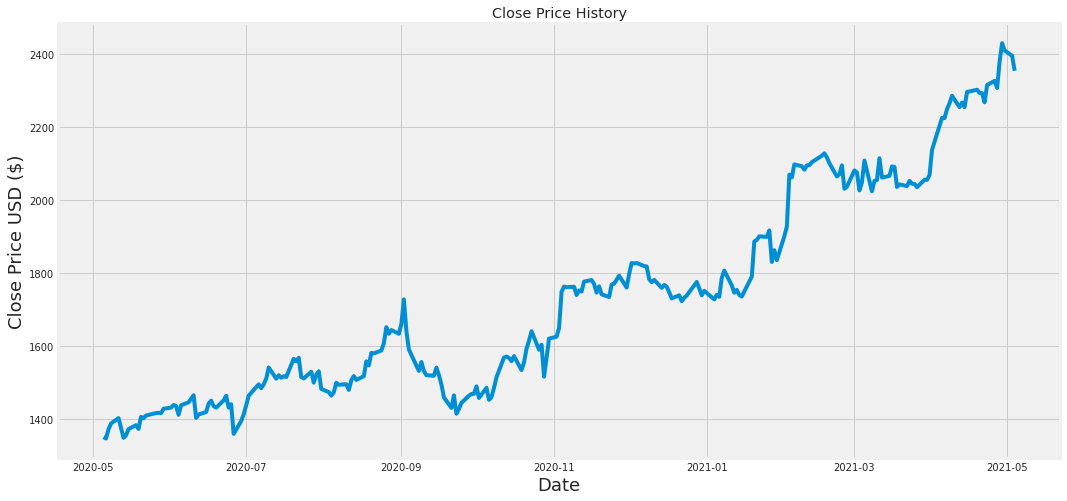

In [8]:
# 종가 시각화
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

증가 추세를 벗어나면 일정 시간동안 추세를 벗어나있다가 느리게 전반적인 추세로 돌아오므로,       
비정상성을 가지는 데이터임을 추측 가능

In [9]:
data.describe()   # max와 min의 차이가 많이나는 상황

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,1749.185482,1709.972187,1727.648749,1730.035372,1.658705e+06,1730.035372
std,286.415409,283.281477,284.422902,284.884983,5.861855e+05,284.884983
min,1357.420044,1323.910034,1335.020020,1347.300049,3.468000e+05,1347.300049
25%,1506.412476,1473.024963,1489.295013,1493.389984,1.289750e+06,1493.389984
50%,1698.356995,1631.484985,1672.942505,1656.544983,1.537550e+06,1656.544983
75%,1979.567505,1936.372498,1947.762543,1951.675018,1.828400e+06,1951.675018
max,2452.377930,2402.280029,2410.330078,2429.889893,4.329100e+06,2429.889893


In [11]:
## Dickey-Fuller의 단위근 검정
from statsmodels.tsa.stattools import adfuller  # augmented 디큐플러 테스트
result=adfuller(data['Close'])  # null은 단위근이 있다 = 이 데이터는 nonstaionary하다 
print('검정통계량 : ', result[0])
print('P-value : ', result[1])

검정통계량 :  0.26295116513879957
P-value :  0.9755793778219942


P-value가 매우 크므로 귀무가설을 기각하지 못한다. 비정상성을 지니는 데이터이다. 

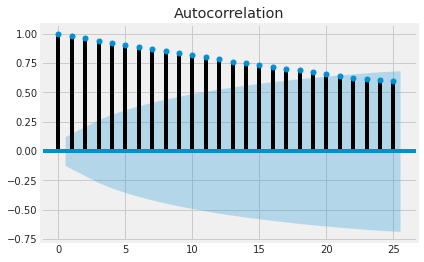

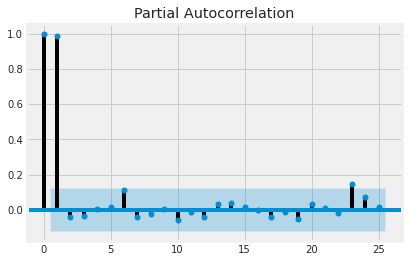

In [14]:
# 자기상관함수, 편자기상관함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'])
plot_pacf(data['Close'])
plt.show()  # 지수 감소형태를 띔

자기상관함수가 선형적으로 매우 느리게 감소하는 모습. 따라서 일일 종가는 비정상시계열이므로 차분이 필요함. 

             High         Low        Open       Close      Volume   Adj Close
count  251.000000  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.002188    0.002180    0.002278    0.002212    0.000242    0.002212
std      0.016338    0.015898    0.018519    0.017793    0.345806    0.017793
min     -0.050647   -0.049079   -0.057493   -0.058155   -1.092248   -0.058155
25%     -0.006932   -0.006816   -0.007590   -0.006282   -0.197411   -0.006282
50%      0.001190    0.003071    0.001861    0.003092   -0.012036    0.003092
75%      0.009999    0.011409    0.012463    0.012355    0.185393    0.012355
max      0.078985    0.053832    0.093825    0.071353    1.390467    0.071353


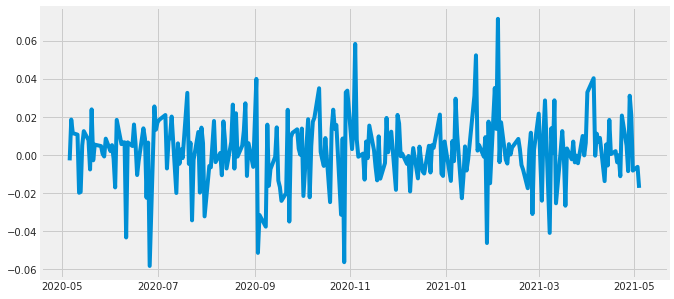

In [15]:
## 로그수익률로 변화 (차분작업)
datapct=data.pct_change()
logreturn=np.log(1+datapct)  # 차분의 역할
logreturn.head()
print(logreturn.describe())  # log return 으로 바꿈
plt.figure(figsize=(10,5))
plt.plot(logreturn['Close'])
plt.show()  # 0을 중심으로 매우 왔다갔다하므로 stationary

로그 수익률 전환 결과 0을 중심으로 왔다갔다하므로 정상시계열일 가능성이 높음

In [17]:
from statsmodels.tsa.stattools import adfuller  ## 차분 후 디큐플러테스트 적용
logreturn=logreturn.dropna()  ## 차분을 취했기에 missing이 발생 > drop 해주기!
result=adfuller(logreturn['Close'])
print('검정통계량 : ', result[0])
print('P-value : ', result[1])

검정통계량 :  -16.83513098629889
P-value :  1.1497419236553939e-29


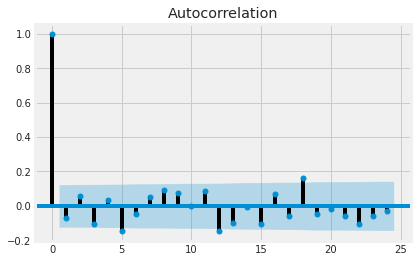

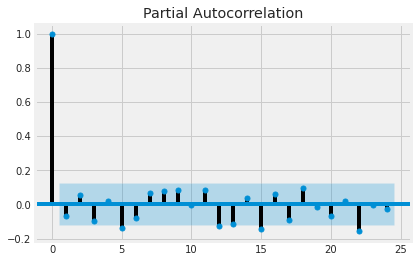

<class 'pandas.core.frame.DataFrame'>


In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(logreturn['Close'])
plot_pacf(logreturn['Close'])
plt.show()
print(type(logreturn))

일일 종가 로그수익률의 acf와 pacf는 모두 절단형태를 띄는 모습 !    
p는 우선 14로 설정

In [19]:
logr1=logreturn['Close'].values
print(type(logr1))
print(logr1.shape)  # 251개까지 log return이 늘어져있음
logr=logr1.reshape(1,-1)
print(logr.shape)
inte=24
x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)
print(type(x))
print(type(y))
x=np.asarray(x)
y=np.asarray(y)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)
x_train=x[:210]
x_test=x[210:]
y_train=y[:210]
y_test=y[210:]

<class 'numpy.ndarray'>
(251,)
(1, 251)
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(227, 24)
(227,)


## Modeling

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
from tensorflow.keras import regularizers
model=Sequential()
## 단순 자기회귀모형(AR)
model.add(Dense(1,input_shape=(24,)))  # x변수가 24개 있을 때 regression 모형과 같음
# 이거의 계수만 보게되면 통계적으로 interpretation이 가능함

### 여기는 overfitting 조절이 어려움
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])  # loss는 mae

model.fit(x_train,y_train,epochs=30,batch_size=32)  # 회귀모형을 32개 쓴 것과 같음 > 통계적으로 해석을 할 수 있어야함
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)

print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 3ms/step - loss: 8.0717e-04 - mae: 0.0226
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 8.3457e-04 - mae: 0.0230
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 7.7590e-04 - mae: 0.0219
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 8.5735e-04 - mae: 0.0234
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 7.3666e-04 - mae: 0.0215
Epoch 6/30
7/7 [==============================] - 0s 3ms/step - loss: 6.2791e-04 - mae: 0.0203
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 7.4925e-04 - mae: 0.0215
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 6.8051e-04 - mae: 0.0208
Epoch 9/30
7/7 [==============================] - 0s 2ms/step - loss: 6.3449e-04 - mae: 0.0200
Epoch 10/30
7/7 [==============================] - 0s 3ms/step - loss: 7.1633e-04 - mae: 0.0209
Epoch 11/30
7/7 [==============================] 

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(Dense(32,activation='relu',input_shape=(24,)))
model.add(Dense(1))                

# regularization은 전체 파라미터 값을 왜곡시킨다. but 중간에 dense가 있으면 regularization이나 dropout을 넣어도됨. 
# 여기는 얼마든지 오버피팅을 조절 가능
## 여기는 통계적모형보다 훨씬 flexible하고 generalized 할 수 있음 

model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 1s 4ms/step - loss: 5.3417e-04 - mae: 0.0178
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 4.7465e-04 - mae: 0.0163
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 4.0406e-04 - mae: 0.0154
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 3.1395e-04 - mae: 0.0133
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 3.1714e-04 - mae: 0.0138
Epoch 6/30
7/7 [==============================] - 0s 3ms/step - loss: 3.2245e-04 - mae: 0.0133
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 3.5113e-04 - mae: 0.0141
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 2.9146e-04 - mae: 0.0123
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 2.7257e-04 - mae: 0.0124
Epoch 10/30
7/7 [==============================] - 0s 3ms/step - loss: 3.0752e-04 - mae: 0.0133
Epoch 11/30
7/7 [==============================] 

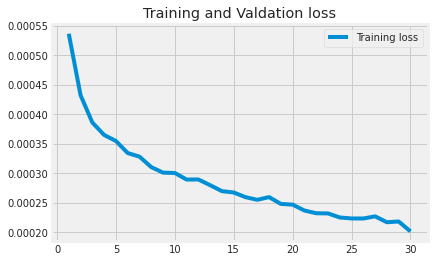

In [27]:
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

In [24]:
## LSTM
x_train=x_train.reshape(-1,1,24)
x_test=x_test.reshape(-1,1,24)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(LSTM(32, input_shape=(1,24)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 4ms/step - loss: 3.5226e-04 - mae: 0.0136
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 3.6565e-04 - mae: 0.0141
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 3.5727e-04 - mae: 0.0143
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 3.6042e-04 - mae: 0.0140
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 3.6170e-04 - mae: 0.0138
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 3.6126e-04 - mae: 0.0137
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 3.7430e-04 - mae: 0.0150
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 3.0999e-04 - mae: 0.0129
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 2.8501e-04 - mae: 0.0126
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 3.1328e-04 - mae: 0.0130
Epoch 11/30
7/7 [==============================] 

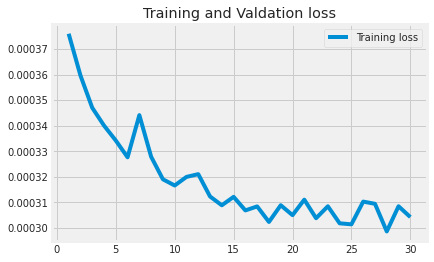

In [25]:
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

In [23]:
# GRU
model=Sequential()
model.add(GRU(32, input_shape=(1,24)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
7/7 [==============================] - 2s 4ms/step - loss: 4.1148e-04 - mae: 0.0156
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 3.3262e-04 - mae: 0.0140
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 3.9577e-04 - mae: 0.0153
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 3.7307e-04 - mae: 0.0150
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 2.9075e-04 - mae: 0.0127
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 3.6630e-04 - mae: 0.0144
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 3.5418e-04 - mae: 0.0137
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 3.2571e-04 - mae: 0.0134
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 3.1203e-04 - mae: 0.0134
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 3.2833e-04 - mae: 0.0136
Epoch 11/30
7/7 [==============================] 